<a href="https://colab.research.google.com/github/udhaya28031995/Spark-The-Definitive-Guide/blob/master/primary_dataset_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Cart Abandonment Analysis  
## Primary Dataset – Behavioral Modeling

---

## 🎯 Objective

The objective of this notebook is to:

1. Analyze behavioral patterns of users in an e-commerce setting.
2. Build a Random Forest model to predict cart abandonment.
3. Identify the most important behavioral drivers influencing abandonment.
4. Visualize patterns and interpret findings for UX and business implications.

---

## 🧠 Features Used

- `pages_visited` → Navigation depth
- `time_on_site` → User engagement duration
- `cart_value` → Monetary value of cart

## 🎯 Target Variable

- `abandoned`
    - 1 = Cart Abandoned
    - 0 = Purchase Completed

---

This notebook is fully executable in Google Colab.


In [3]:
# ==================================================
# Import Required Libraries
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

sns.set_style("whitegrid")


In [6]:
# ==================================================
# FULL DATASET SETUP + LOAD (ALL-IN-ONE CELL)
# ==================================================

import os
import pandas as pd

# Step 1: Install Kaggle (quiet mode)
!pip install -q kaggle

# Step 2: Upload kaggle.json (only if not already configured)
if not os.path.exists('/root/.kaggle/kaggle.json'):
    from google.colab import files
    print("Please upload your kaggle.json file:")
    files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download dataset
print("Downloading dataset from Kaggle...")
!kaggle datasets download -d sahideseker/online-shopping-abandonment-prediction -q

# Step 4: Unzip dataset
!unzip -o online-shopping-abandonment-prediction.zip -d dataset > /dev/null

# Step 5: Detect and load CSV automatically
files = os.listdir('/content/dataset')
csv_files = [f for f in files if f.endswith('.csv')]

if len(csv_files) == 0:
    raise Exception("No CSV file found in dataset folder.")

file_path = '/content/dataset/' + csv_files[0]
df = pd.read_csv(file_path)

print("Loaded file:", csv_files[0])
print("Dataset Shape:", df.shape)
display(df.head())


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sahideseker/online-shopping-abandonment-prediction
License(s): CC-BY-SA-4.0
Loaded file: shopping_abandonment.csv
Dataset Shape: (1000, 5)


,session_id,pages_visited,time_on_site,cart_value,abandoned
0,SID1,8,548,23.49,0
1,SID2,13,226,112.20,0
2,SID3,18,472,214.70,1
3,SID4,13,529,294.08,0
4,SID5,9,936,293.16,1


In [7]:
# ==================================================
# DATA PREPARATION + TRAIN/TEST SPLIT
# ==================================================

# Check columns first
print("Columns in dataset:")
print(df.columns)

# Select relevant features (adjust if needed)
df_model = df[['session_id', 'pages_visited', 'time_on_site', 'cart_value', 'abandoned']].copy()

# Ensure target is numeric
df_model['abandoned'] = df_model['abandoned'].astype(int)

# Display basic info
print("\nSelected Features Preview:")
display(df_model.head())

print("\nClass Distribution:")
print(df_model['abandoned'].value_counts(normalize=True))

# Split features & target
X = df_model.drop(['session_id', 'abandoned'], axis=1)
y = df_model['abandoned']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain/Test Split Completed")
print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)


Columns in dataset:
Index(['session_id', 'pages_visited', 'time_on_site', 'cart_value',
       'abandoned'],
      dtype='object')

Selected Features Preview:


,session_id,pages_visited,time_on_site,cart_value,abandoned
0,SID1,8,548,23.49,0
1,SID2,13,226,112.20,0
2,SID3,18,472,214.70,1
3,SID4,13,529,294.08,0
4,SID5,9,936,293.16,1



Class Distribution:
abandoned
0    0.69
1    0.31
Name: proportion, dtype: float64

Train/Test Split Completed
Training Size: (800, 3)
Testing Size: (200, 3)


Model training completed.



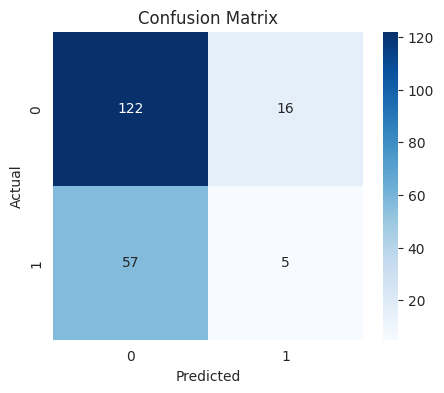


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       138
           1       0.24      0.08      0.12        62

    accuracy                           0.64       200
   macro avg       0.46      0.48      0.45       200
weighted avg       0.54      0.64      0.57       200



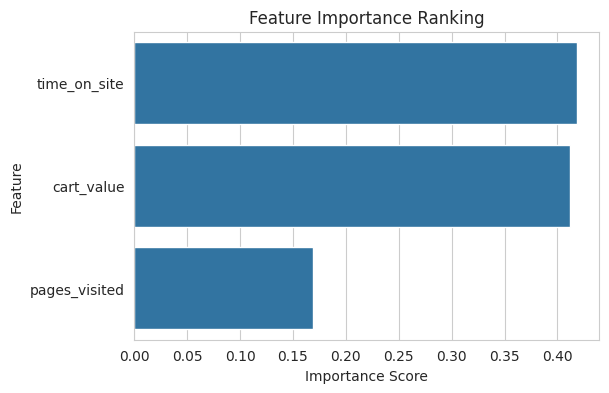

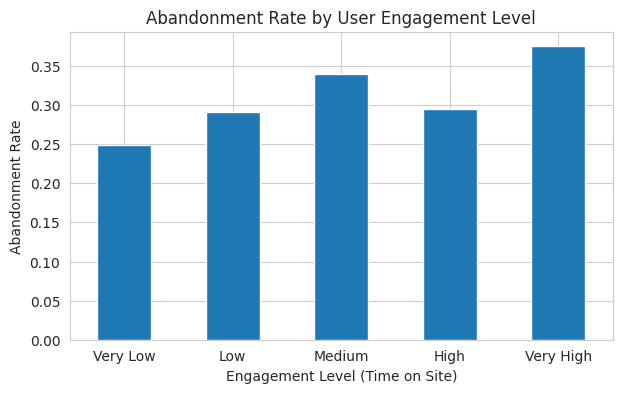

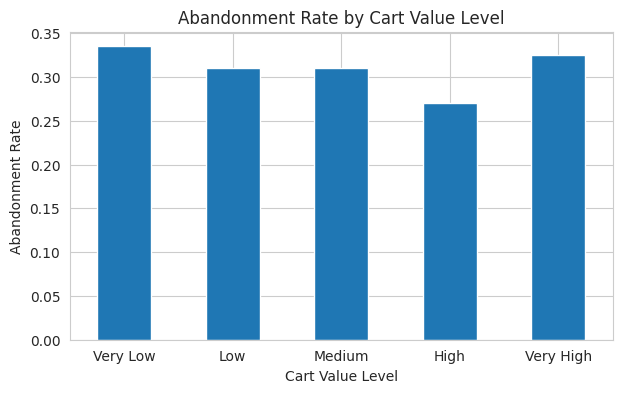

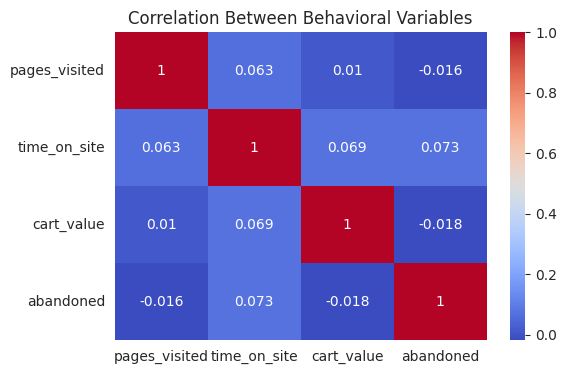

In [11]:
# ==================================================
# MODEL TRAINING + EVALUATION + INSIGHT VISUALIZATION
# ==================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# ----------------------------
# Train Model
# ----------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
print("Model training completed.\n")

# ----------------------------
# Confusion Matrix
# ----------------------------
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ----------------------------
# Feature Importance
# ----------------------------
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importance Ranking")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# ==================================================
# STRONGER BEHAVIORAL INSIGHT GRAPHS
# ==================================================

# ----------------------------
# Abandonment by Engagement Level (Time on Site)
# ----------------------------

labels = ["Very Low", "Low", "Medium", "High", "Very High"]

df_model['engagement_level'] = pd.qcut(
    df_model['time_on_site'],
    q=5,
    labels=labels,
    duplicates='drop'
)

time_abandon_rate = df_model.groupby(
    'engagement_level', observed=True
)['abandoned'].mean()

plt.figure(figsize=(7,4))
time_abandon_rate.plot(kind='bar')
plt.title("Abandonment Rate by User Engagement Level")
plt.ylabel("Abandonment Rate")
plt.xlabel("Engagement Level (Time on Site)")
plt.xticks(rotation=0)
plt.show()


# ----------------------------
# Abandonment by Cart Value Level
# ----------------------------

df_model['cart_value_level'] = pd.qcut(
    df_model['cart_value'],
    q=5,
    labels=labels,
    duplicates='drop'
)

cart_abandon_rate = df_model.groupby(
    'cart_value_level', observed=True
)['abandoned'].mean()

plt.figure(figsize=(7,4))
cart_abandon_rate.plot(kind='bar')
plt.title("Abandonment Rate by Cart Value Level")
plt.ylabel("Abandonment Rate")
plt.xlabel("Cart Value Level")
plt.xticks(rotation=0)
plt.show()


# ----------------------------
# Correlation Heatmap
# ----------------------------

plt.figure(figsize=(6,4))
sns.heatmap(
    df_model[['pages_visited','time_on_site','cart_value','abandoned']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Between Behavioral Variables")
plt.show()
